<a href="https://colab.research.google.com/github/ludlev2/ml_project_cse204/blob/main/Datasets-under-consideration/London/RQ1_TS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [91]:
from datetime import datetime

import pandas as pd
import matplotlib.pyplot as plt

import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf

from pmdarima import auto_arima

In [70]:
def plot_decomp(timeseries: pd.DataFrame) -> None:
  result = seasonal_decompose(timeseries, model='additive')

  fig = plt.figure()  
  fig = result.plot()  
  fig.set_size_inches(15, 12)


In [71]:
df = pd.read_csv('UK_international-visits.csv')

regions = ['North', 'Midlands', 'East', 'South', 'London']
london = ['LONDON']
south = ['SOUTH WEST', 'SOUTH EAST', 'SOUTHERN ENGLAND', ' CHANNEL ISLANDS',  ' ISLE OF MAN']
east = ['EAST OF ENGLAND', 'REST OF ENGLAND']
midlands = ['WEST MIDLANDS', 'EAST MIDLANDS', 'CENTRAL ENGLAND', 'YORKSHIRE']
north = ['NORTH EAST', 'NORTH WEST', ' NORTHERN IRELAND', 'SCOTLAND', 'WALES', "ENGLAND'S NORTH COUNTRY"]
#map regions to areas
df['area'] = df['area'].replace(london, 'London')
df['area'] = df['area'].replace(south, 'South')
df['area'] = df['area'].replace(east, 'East')
df['area'] = df['area'].replace(midlands, 'Midlands')
df['area'] = df['area'].replace(north, 'North')

df['area'].unique()
#drop 'ALL STAYING VISITS' and 'OIL RIGS/TRAVELLING' and 'TOTAL ENGLAND'
df = df[df.area != 'ALL STAYING VISITS']
df = df[df.area != ' OIL RIGS/TRAVELLING']
df = df[df.area != 'TOTAL ENGLAND']
df['area'].unique()

# combine the yeae and quarter columns
quarters = df['quarter'].unique().astype(str)
#map quarters to numbers [0,0.25,0.5,0.75]
mapping = {
    quarters[0]:'03-31', 
    quarters[1]:'06-30', 
    quarters[2]:'09-30',
    quarters[3]:'12-31'
}
df['quarter'] = df['quarter'].replace(mapping)

#combine year and quarter columns by adding them together, casting them as floats
#map '2019P' to 2019
df['year'] = df['year'].replace('2019P', '2019')
df['year'] = df['year'].astype(str)
df['date'] = (df['year'] + '-' + df['quarter'])

df[['visits', 'date']].groupby('date').sum().to_csv('uk_international_visits_clean.csv')

<ipython-input-71-ff45f1a8857b>:1: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('UK_international-visits.csv')


In [72]:
 visits = pd.read_csv("uk_international_visits_clean.csv", parse_dates=[0]).set_index('date')

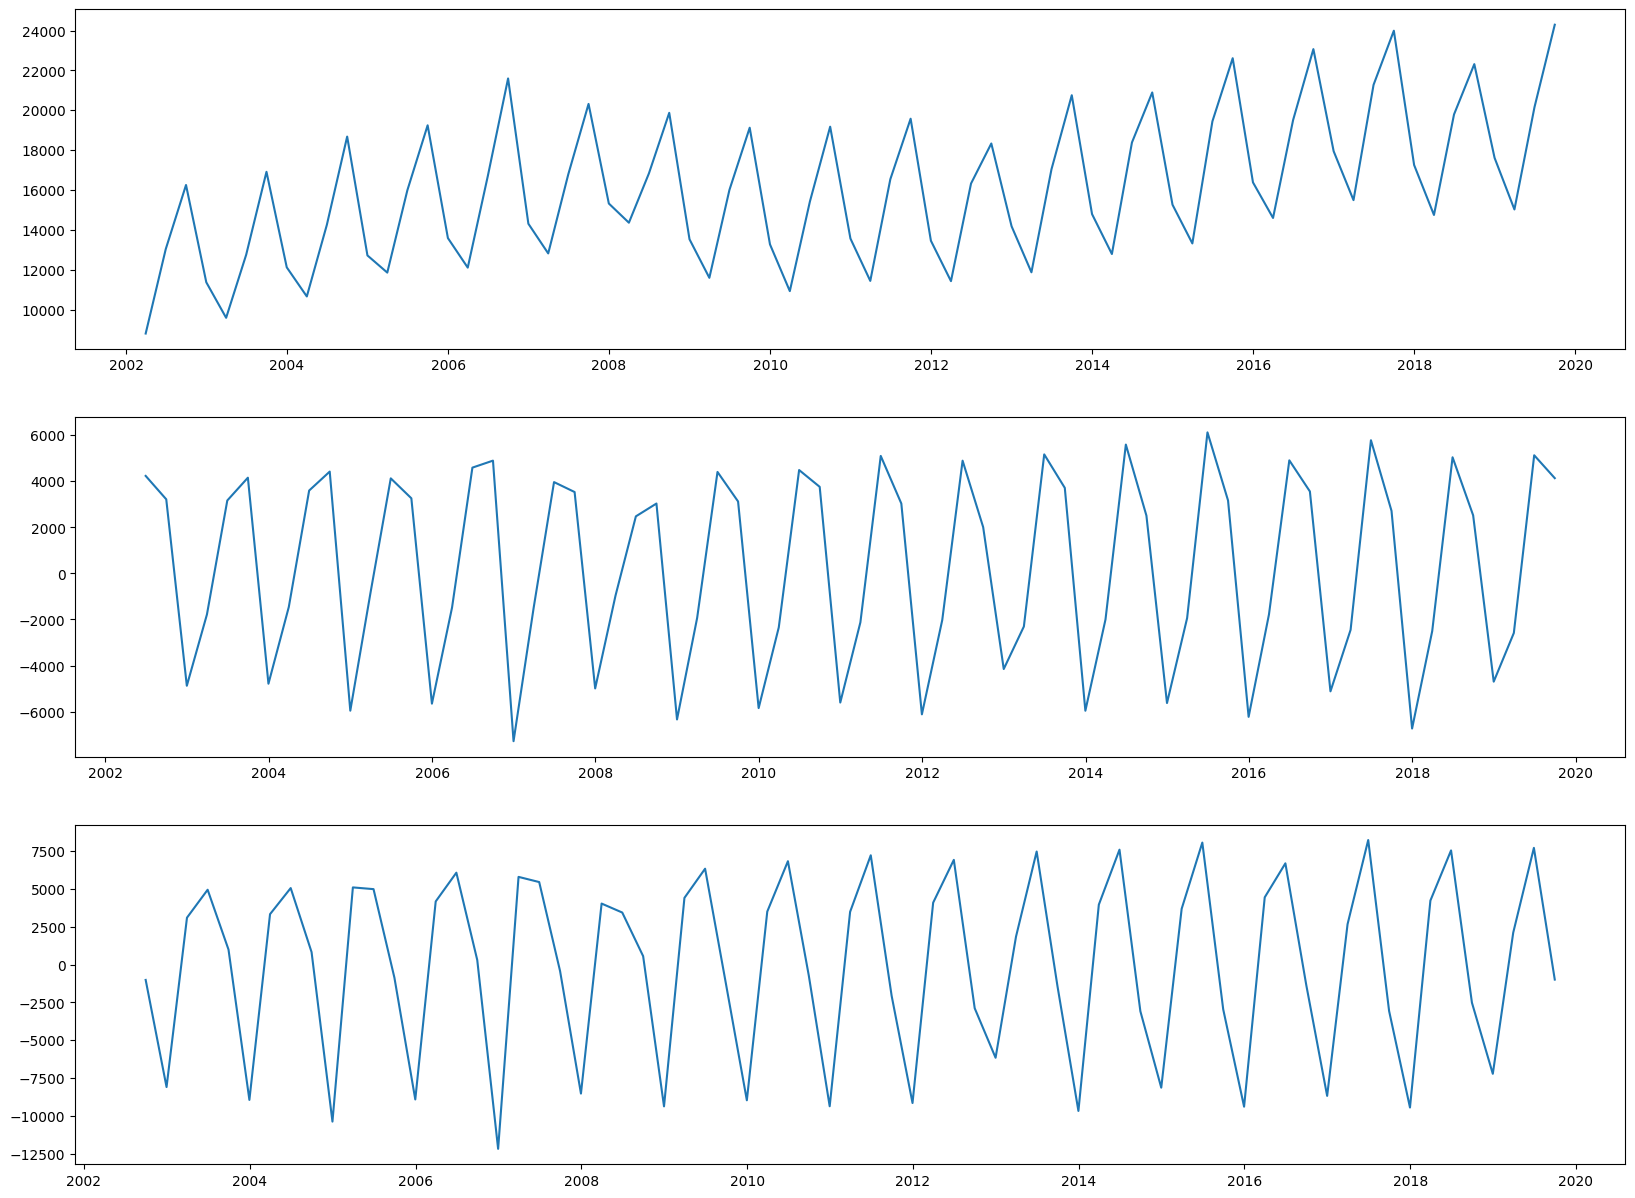

In [103]:
visits_diff_1 = visits.diff().dropna()
visits_diff_2 = visits.diff().diff().dropna()

fig, axs = plt.subplots(nrows=3, figsize=(20, 15))

axs[0].plot(visits)
axs[1].plot(visits_diff_1)
axs[2].plot(visits_diff_2)

In [74]:
visits_train = visits[visits.index < datetime(2012, 7, 1)]
visits_test  = visits[visits.index >= datetime(2012, 7, 1)]

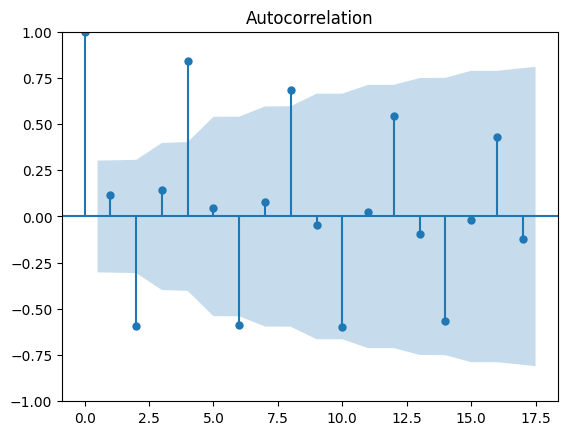

In [76]:
plot_decomp(visits_train)
x = plot_acf(visits_train)

<Figure size 640x480 with 0 Axes>

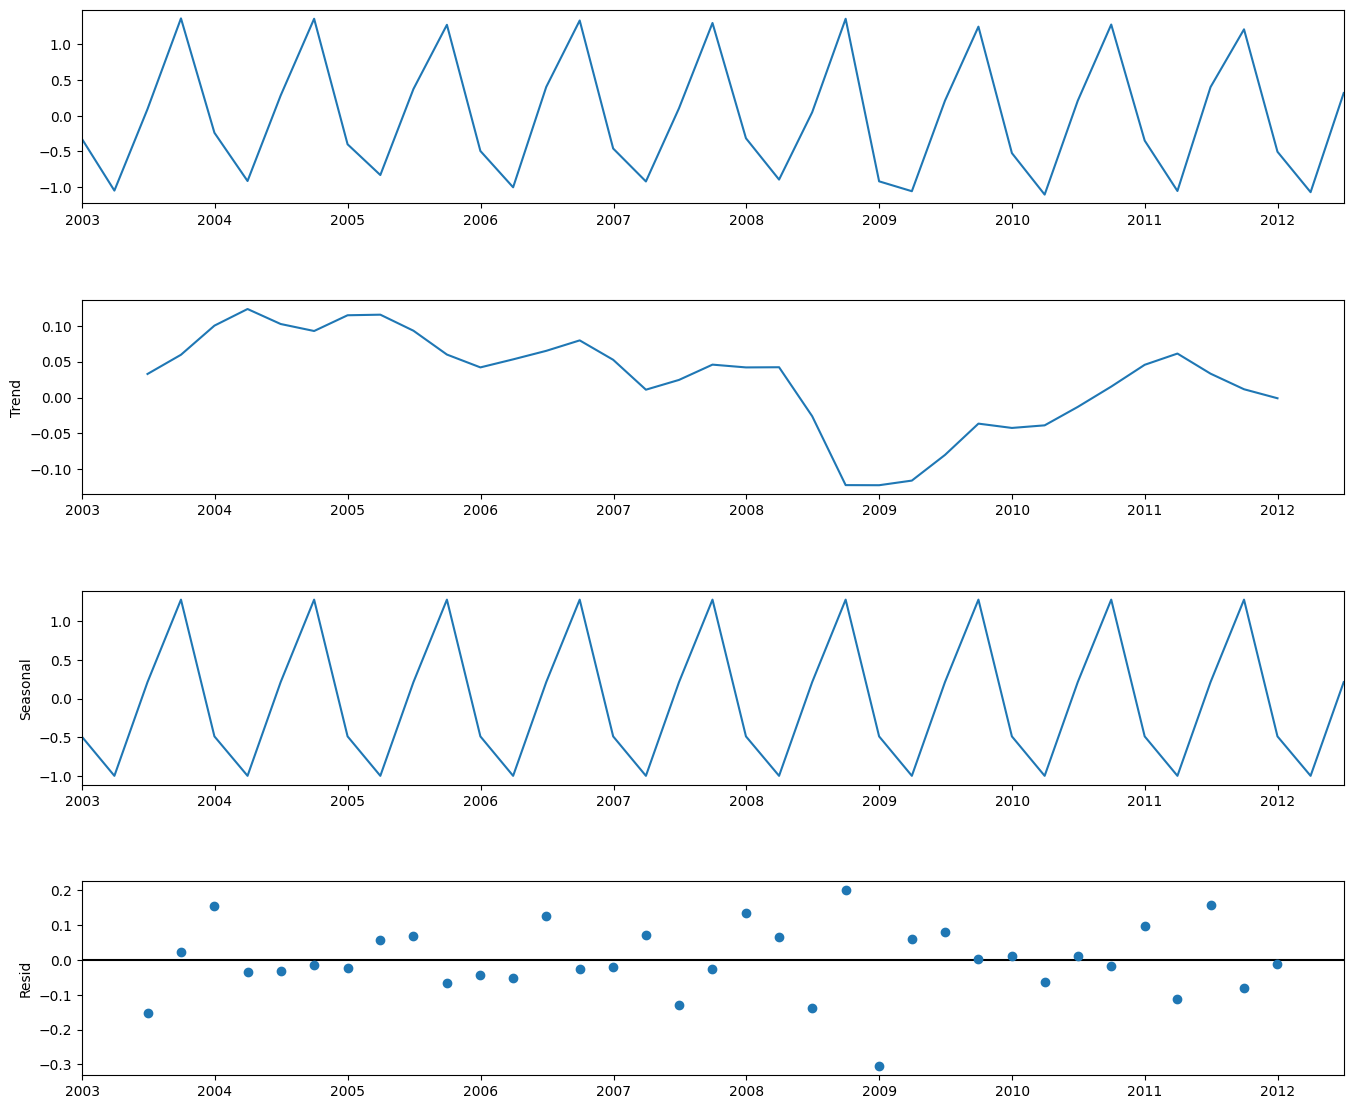

In [78]:
visits_detrended = (visits_train - visits_train.rolling(4).mean()) / visits_train.rolling(4).std()
plot_decomp(visits_detrended.dropna())

<Figure size 640x480 with 0 Axes>

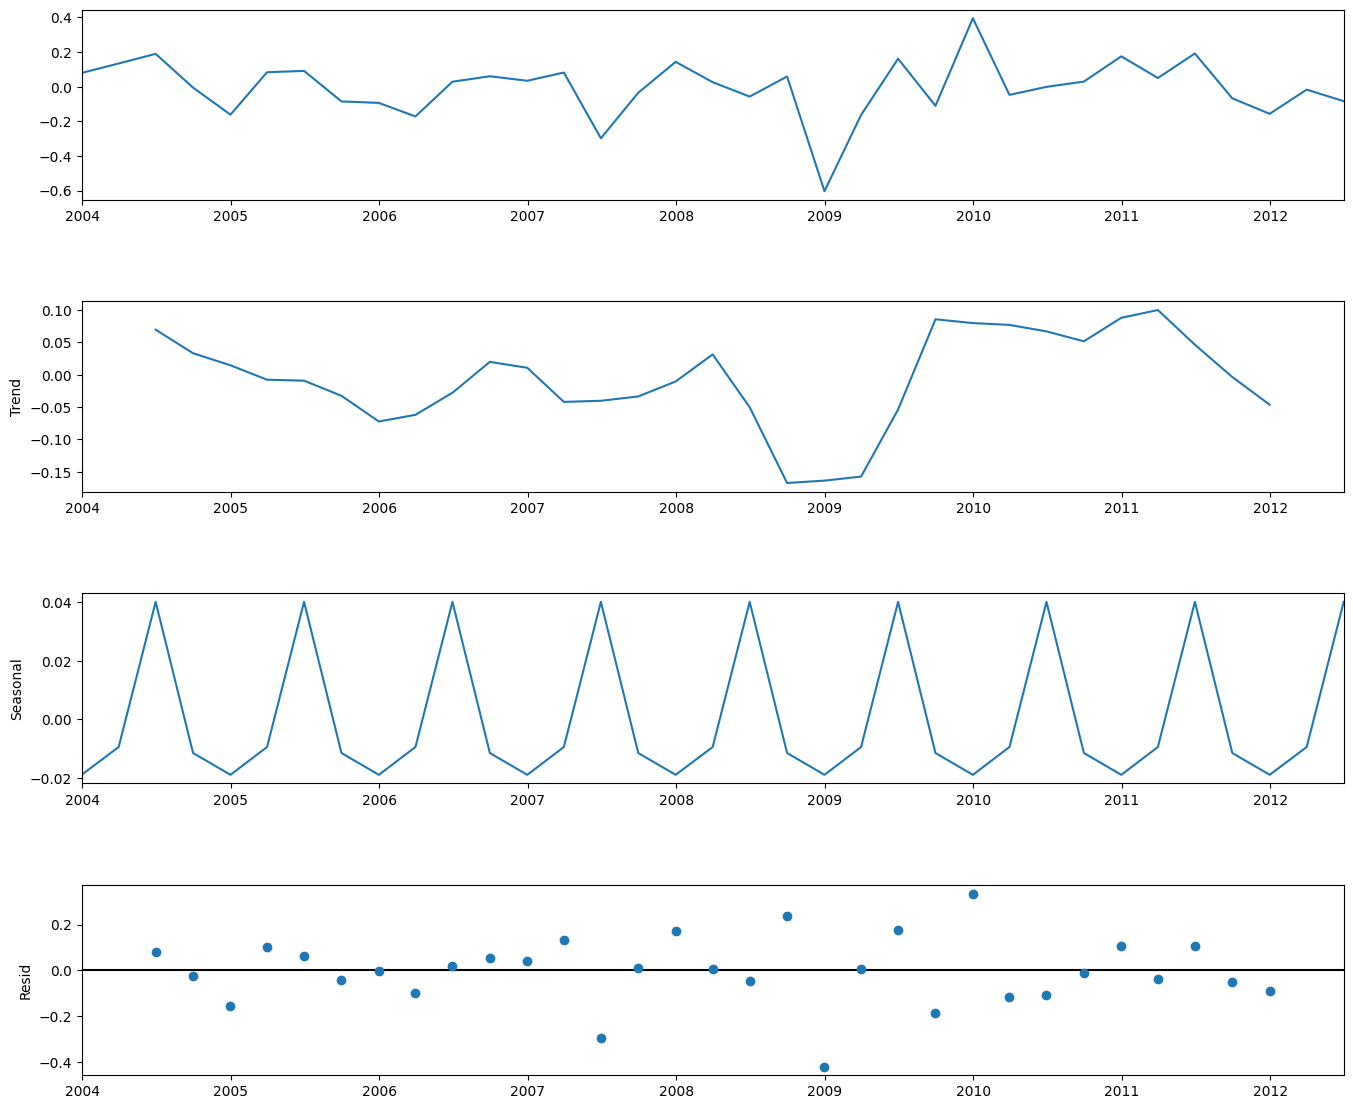

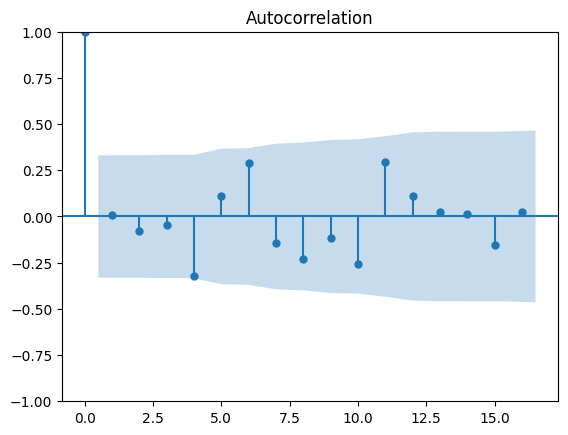

In [81]:
visits_lagged = (visits_detrended - visits_detrended.shift(4)).dropna()
plot_decomp(visits_lagged)
x = plot_acf(visits_lagged)

In [89]:
stepwise_model = auto_arima(
    visits_train, start_p=1, start_q=1,
    max_p=3, max_q=3, m=4,
    start_P=0, seasonal=True,
    d=1, D=1, trace=True,
    error_action='ignore',  
    suppress_warnings=True, 
    stepwise=True
)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[4]             : AIC=607.779, Time=0.13 sec
 ARIMA(0,1,0)(0,1,0)[4]             : AIC=611.186, Time=0.01 sec
 ARIMA(1,1,0)(1,1,0)[4]             : AIC=608.279, Time=0.06 sec
 ARIMA(0,1,1)(0,1,1)[4]             : AIC=607.295, Time=0.06 sec
 ARIMA(0,1,1)(0,1,0)[4]             : AIC=613.151, Time=0.02 sec
 ARIMA(0,1,1)(1,1,1)[4]             : AIC=609.260, Time=0.22 sec
 ARIMA(0,1,1)(0,1,2)[4]             : AIC=609.249, Time=0.26 sec
 ARIMA(0,1,1)(1,1,0)[4]             : AIC=608.155, Time=0.17 sec
 ARIMA(0,1,1)(1,1,2)[4]             : AIC=inf, Time=0.41 sec
 ARIMA(0,1,0)(0,1,1)[4]             : AIC=605.981, Time=0.13 sec
 ARIMA(0,1,0)(1,1,1)[4]             : AIC=608.008, Time=0.10 sec
 ARIMA(0,1,0)(0,1,2)[4]             : AIC=607.879, Time=0.16 sec
 ARIMA(0,1,0)(1,1,0)[4]             : AIC=606.400, Time=0.05 sec
 ARIMA(0,1,0)(1,1,2)[4]             : AIC=inf, Time=0.31 sec
 ARIMA(1,1,0)(0,1,1)[4]             : AIC=607.636, Time

In [92]:
model = ARIMA(visits_train, order=(0, 1, 0), seasonal_order=(0, 1, 1, 4)).fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency Q-DEC will be used.
  self._init_dates(dates, freq)


<Axes: >

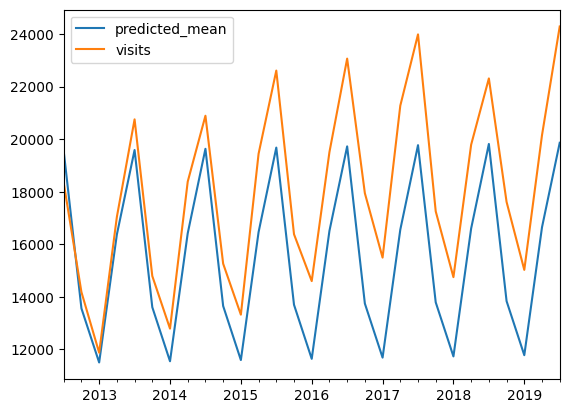

In [100]:
pd.concat(
    [
      pd.DataFrame(model.predict(start=visits_test.index[0], end=visits_test.index[-1])),
      visits_test
    ],
    axis=1
).plot()